In [1]:
#importing the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#Get the dataset
df = pd.read_csv(r'./output/combined_data.csv')

# Data Visualisation

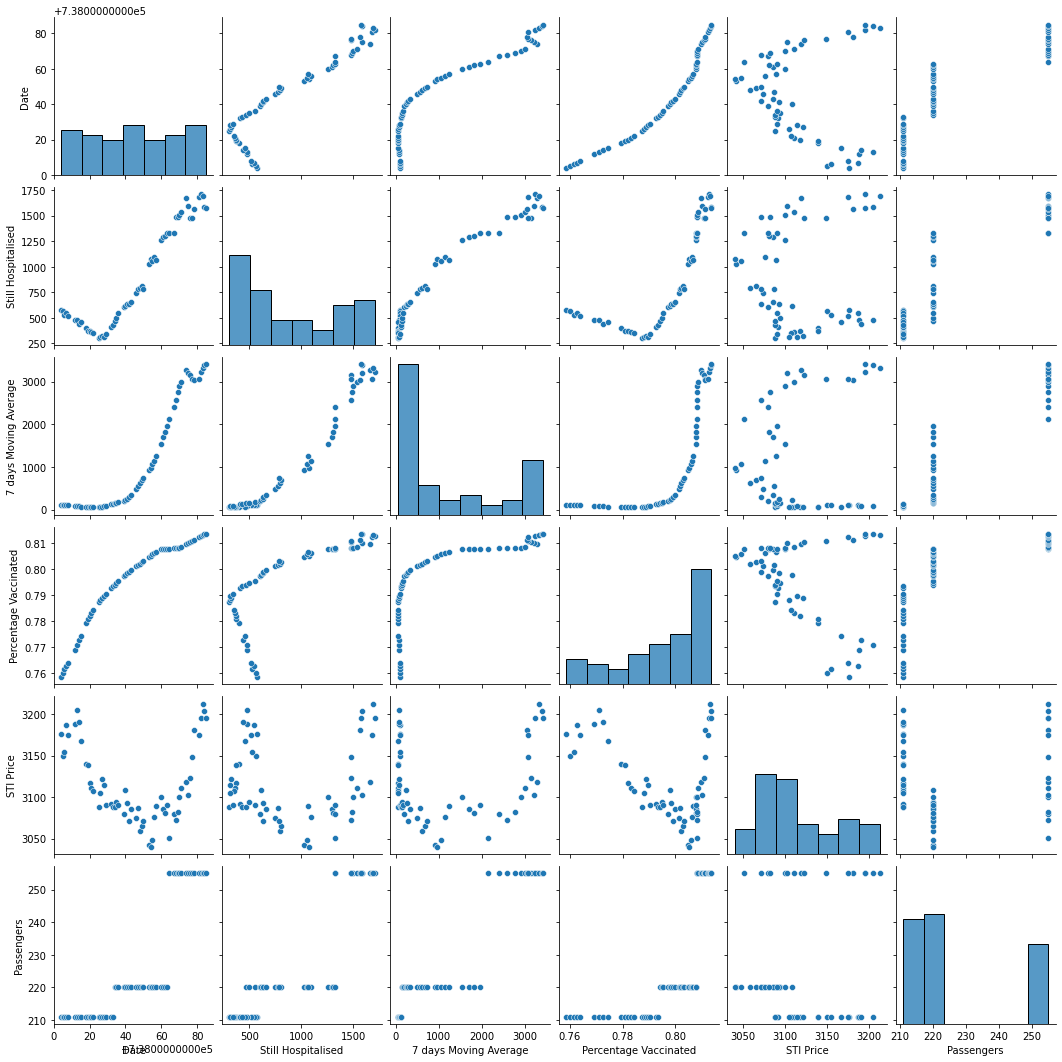

In [3]:
pp = sns.pairplot(data=df)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
# Further viz with q-q plot to visualize the distribution of the data

### Plotting Scatter Plots

In [4]:
df.columns

Index(['Date', 'Still Hospitalised', 'Phase', '7 days Moving Average',
       'Percentage Vaccinated', 'STI Price', 'Passengers'],
      dtype='object')

In [5]:
myplot = sns.boxplot(x='Phase_Phase 2 (Heightened Alert)', y='STI Price', data=df)

ValueError: Could not interpret input 'Phase_Phase 2 (Heightened Alert)'

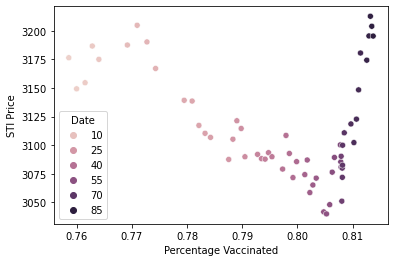

In [6]:
myplot = sns.scatterplot(hue = 'Date',x='Percentage Vaccinated', y='STI Price', data=df)

visualising how LR is not a good predictor of the target variable

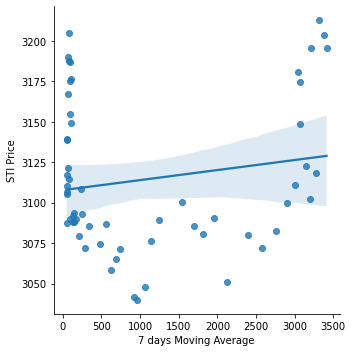

In [7]:
myplot = sns.lmplot(x='7 days Moving Average', y='STI Price', data=df) 

Polynomial Regression might be better

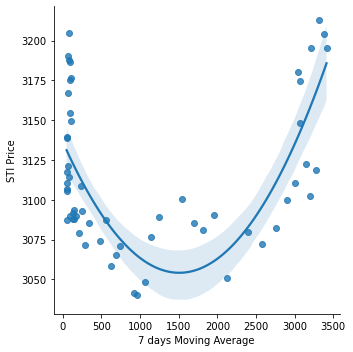

In [8]:
myplot = sns.lmplot(x='7 days Moving Average', y='STI Price', data=df,order = 2) 

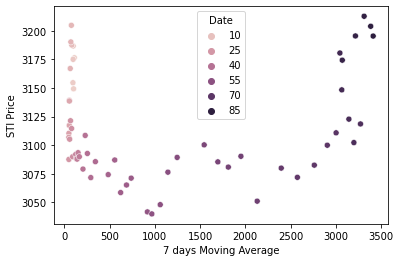

In [9]:
myplot = sns.scatterplot(hue = 'Date',x='7 days Moving Average', y='STI Price', data=df)

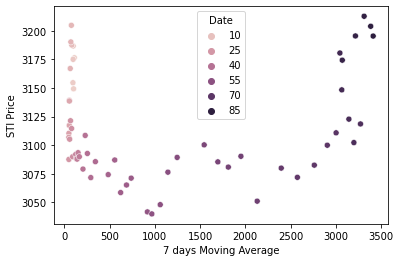

In [45]:
myplot = sns.scatterplot(hue = 'Date',x='7 days Moving Average', y='STI Price', data=df)

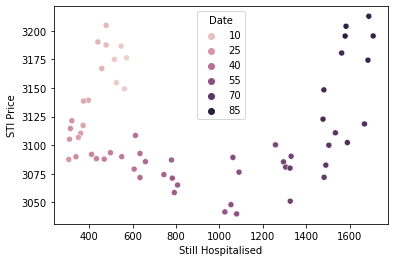

In [46]:
myplot = sns.scatterplot(x='Still Hospitalised', y='STI Price', hue = 'Date', data=df)


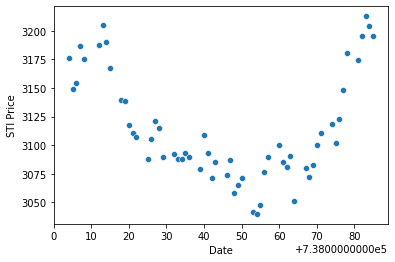

In [47]:
myplot2 = sns.scatterplot(x='Date', y='STI Price', data=df)

# Modelling

In [10]:
def normalize_z(dfin):
   
    dfout = (dfin - dfin.mean(axis=0))/dfin.std(axis=0)

    return dfout

def normalize_minmax(dfin):

    dfout = (dfin - dfin.min(axis=0))/(dfin.max(axis=0)-dfin.min(axis=0))
            
    return dfout


def get_features_targets(df, feature_names, target_names):
    df_feature = df.loc[:,feature_names]
    df_target = df.loc[:,target_names]
    
    return df_feature, df_target

def prepare_feature(df_feature):
    n = df_feature.shape[0]
    ones = np.ones(n).reshape(n,1)

    return np.concatenate((ones,df_feature.to_numpy()),axis = 1)

def prepare_target(df_feature):
    return df_feature.to_numpy()

def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    X = prepare_feature(df_feature)

    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)


def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    np.random.seed(random_state)
    TestSize = int(test_size*len(df_feature))
    testchoice = np.random.choice(len(df_feature),size = TestSize, replace = False)
    remainder = []
    for i in df_feature.index:
        if i not in testchoice:
            remainder.append(i)
    trainchoice = np.random.choice(remainder, size = len(remainder),replace = False)
        
    df_feature_train = df_feature.iloc[trainchoice]
    df_target_train = df_target.iloc[trainchoice]
    df_feature_test = df_feature.iloc[testchoice]
    df_target_test = df_target.iloc[testchoice]
    
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    rss = np.sum((ypred - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)
    
    r2 = 1 - (rss / tss)
    
    return r2

def mean_squared_error(target, pred):
    n = target.shape[0]
    error = target-pred
    mse = np.matmul(error.T,error)/n
    
    return mse

def adjusted_r2_score(y, ypred):
    # The reason for this is that the r2 score is not adjusted for the number of observations
    # Since R2 always increases as you add more predictors to a model, adjusted R2 can serve as a metric that tells you how useful a model is, adjusted for the number of predictors in a model.
    # The adjusted R2 score is calculated as 1 - (1-r2)*(n-1)/(n-p-1)
    r2 = r2_score(y,ypred)
    n = y.shape[0]
    k = y.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
    
    return adj_r2

def evaluate_model(y, ypred):
    r2 = r2_score(y, ypred)
    adjusted_r2 = adjusted_r2_score(y, ypred)
    mse = mean_squared_error(y, ypred)

    print(f"mse : {mse}\n")
    print(f"r2 : {r2}")
    print(f"adjusted r2 : {adjusted_r2}")


In [11]:
def compute_cost(X, y, beta):
    m = X.shape[0]
    y_pred = np.matmul(X,beta)
    error = y_pred - y
    
    # Matrix multiplcation does both sum and square
    J = (1/(2*m))*np.matmul(error.T,error)
    
    return J[0][0] # Extract a scalar value from the 1 x 1 matrix



def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = np.zeros(num_iters)
    
    for i in range(num_iters):
        yp = np.matmul(X,beta)
        error = yp - y
        beta = beta - (alpha/m) * np.matmul(X.T,error)
#         beta = beta - (alpha/m)*np.matmul(X.T,np.matmul(X,beta)-y)
        cost = compute_cost(X,y,beta)
#         print(cost)
        J_storage[i] = cost
#         print(J_storage[i])
    
    
    return beta, J_storage

In [12]:
list(df.columns[:-1])

['Date',
 'Still Hospitalised',
 'Phase',
 '7 days Moving Average',
 'Percentage Vaccinated',
 'STI Price']

Using all features as benchmark

In [51]:
feature_column = ['Date',
 'Still Hospitalised',
 '7 days Moving Average',
 'Percentage Vaccinated',
 'Phase_Phase 2 (Heightened Alert)',
 'Phase_Preparatory Stage',
 'Phase_Stabilisation Phase']

# get features and targets from data frame
df_feature, df_target = get_features_targets(df,['Date'],["STI Price"])

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_feature_train_z = normalize_z(df_feature_train)

X = prepare_feature(df_feature_train) # concatenating for the y intercept
target = prepare_target(df_target_train)

iterations = 10
alpha = 0.0001

num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict method to get the predicted values
df_feature_test_z = normalize_z(df_feature_test)
pred = predict(df_feature_test_z,beta)
print(beta)

evaluate_model(df_target_test, pred)

[[6.93951978e+70]
 [5.12167705e+76]]
mse :                        0
STI Price  2.468854e+153

r2 : STI Price   -1.177086e+150
dtype: float64
adjusted r2 : STI Price   -1.255558e+150
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


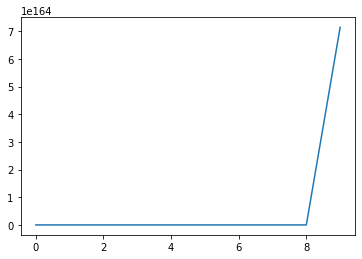

In [52]:
plt.plot(J_storage)

### Normalising Data

In [53]:
feature_column = ['Date',
 'Still Hospitalised',
 '7 days Moving Average',
 'Percentage Vaccinated',
 'Phase_Phase 2 (Heightened Alert)',
 'Phase_Preparatory Stage',
 'Phase_Stabilisation Phase']

# get features and targets from data frame
df_feature, df_target = get_features_targets(df,['Date'],["STI Price"])

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_feature_train_z = normalize_z(df_feature_train)

X = prepare_feature(df_feature_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)

iterations = 10000
alpha = 0.001

num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict method to get the predicted values
df_feature_test_z = normalize_z(df_feature_test)
pred = predict(df_feature_test_z,beta)
print(beta)

evaluate_model(df_target_test, pred)

[[3112.17201423]
 [  -4.50613225]]
mse :                     0
STI Price  2112.41053

r2 : STI Price   -0.007142
dtype: float64
adjusted r2 : STI Price   -0.074285
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [58]:
len(df_feature_test_z)

17

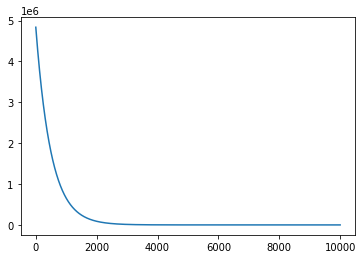

In [56]:
plt.plot(J_storage)

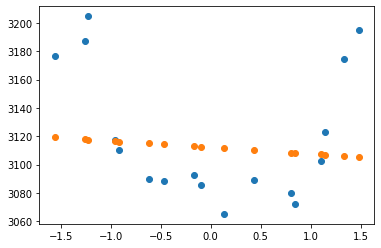

In [174]:
plt.scatter(df_feature_test_z["Date"], df_target_test)
plt.scatter(df_feature_test_z["Date"], pred)

### Using polynomial Features for transformation

In [14]:
def poly_features(df_feature, colname, colname_transformed, degree=2):
    col = df_feature[colname]
    df_feature[colname_transformed] = np.power(col, degree)
    return df_feature

In [29]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date","Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated",2)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3114.68150344]
 [ 104.06631018]
 [-113.80869296]]
mse :                     0
STI Price  766.470101

r2 : STI Price    0.634567
dtype: float64
adjusted r2 : STI Price    0.610205
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [65]:
# convert dataframe to list
df_features_test_list = df_features_test.values.tolist()
df_features_test_list

[[-0.16797556263689653, 0.14091652326043888],
 [0.9056682418813299, 0.7959533187314604],
 [0.16237637721486545, 0.4285464387923033],
 [-0.9938554122663015, -0.8397883780364044],
 [0.9469622343628001, 0.7970117308312237],
 [1.2773141742145622, 0.9772745216071946],
 [1.2360201817330918, 0.9449288812826357],
 [-0.08538757767395605, 0.22898118243888696],
 [-1.3242073521180635, -1.5759785724985487],
 [-0.49832750248865854, -0.19130577270865506],
 [-1.6958532844512957, -2.2714485264004516],
 [0.49272831706662745, 0.6973901163914364],
 [1.6489601065477943, 1.1935311839518792],
 [-1.0351494047477718, -0.9083205606925213],
 [-1.3655013445995337, -1.678276795401853],
 [1.4837841366219133, 1.1105832720005908],
 [-0.6635034724145396, -0.3850600081911466]]

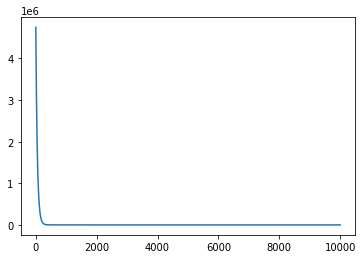

In [28]:
plt.plot(J_storage)

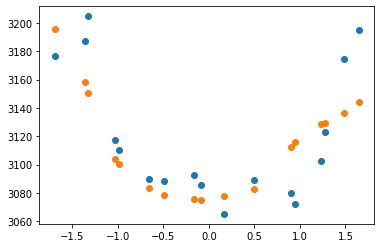

In [178]:
plt.scatter(df_features_test["Date"], df_target_test)
plt.scatter(df_features_test["Date"], pred)

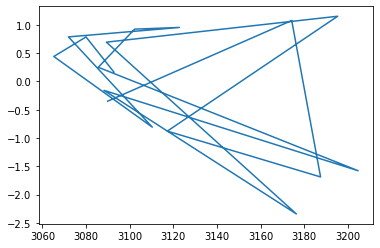

In [179]:
plt.plot(df_target_test,df_features_test["Percentage Vaccinated"])

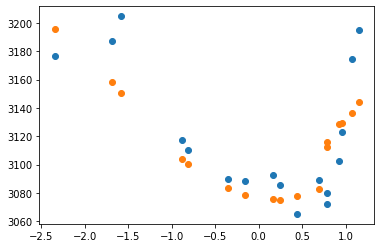

In [180]:
plt.scatter(df_features_test["Percentage Vaccinated"], df_target_test)
plt.scatter(df_features_test["Percentage Vaccinated"], pred)

### Further Experiments

Transforming both P Percentage Vaccinated and Date

In [181]:
df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated")

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 15000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test,beta)

# change target test set to a numpy array
target = df_target.to_numpy()

evaluate_model(df_target_test, pred)

mse :                     0
STI Price  751.803903

r2 : STI Price    0.641559
dtype: float64
adjusted r2 : STI Price    0.617663
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


Using more variables

In [182]:
# Normalize dataset
df_norm = normalize_z(df)

# normalize features
# df_features = normalize_minmax(df_features)

# Extract feature and target
df_feature, df_target = get_features_targets(df,["Still Hospitalised","7 days Moving Average","Percentage Vaccinated"],["STI Price"])



# split data using random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3114.74302959]
 [ 110.96899904]
 [-120.41059048]]
mse :                     0
STI Price  753.869917

r2 : STI Price    0.640574
dtype: float64
adjusted r2 : STI Price    0.616613
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


Using Min Max Norm

In [183]:
# Normalize dataset
# df_norm = normalize_z(df)

# normalize features
df_features = normalize_minmax(df_features)

# Extract feature and target
df_feature, df_target = get_features_targets(df,["Still Hospitalised","7 days Moving Average","Percentage Vaccinated"],["STI Price"])



# split data using random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


[[3118.57986772]
 [ -83.82207865]
 [  53.75342824]]
mse :                      0
STI Price  3840.568862

r2 : STI Price   -0.831083
dtype: float64
adjusted r2 : STI Price   -0.953156
dtype: float64


In [184]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date","Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated", 6)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3114.79831994]
 [ 118.16234835]
 [-127.30082777]]
mse :                     0
STI Price  744.042286

r2 : STI Price    0.64526
dtype: float64
adjusted r2 : STI Price    0.621611
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [185]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date","Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated", 6)

# normalize features
df_features = normalize_minmax(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3120.02106804]
 [ -78.31422789]
 [  48.19806424]]
mse :                     0
STI Price  3588.54009

r2 : STI Price   -0.710923
dtype: float64
adjusted r2 : STI Price   -0.824984
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [186]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated")

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3115.59046068]
 [  51.2336451 ]
 [ -53.88468352]
 [  72.20523737]
 [ -74.58924539]]
mse :                     0
STI Price  932.353395

r2 : STI Price    0.555478
dtype: float64
adjusted r2 : STI Price    0.525843
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


# Date, Still Hospitalised, 7 days Moving Average, % Vaccinated

### 1. Normalise features before splitting (best result)

In [190]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "7 days Moving Average", "7 days Moving Average", 3)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

y = predict(df_features, beta)
results = sm.OLS(y, df_target).fit()
results.summary()

[[3115.52576791]
 [  11.19279925]
 [ -13.76182669]
 [  50.32555698]
 [ -44.22054418]]
mse :                     0
STI Price  794.252532

r2 : STI Price    0.621321
dtype: float64
adjusted r2 : STI Price    0.596076
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.047e+05
Date:                Sun, 21 Nov 2021   Prob (F-statistic):                   2.62e-123
Time:                        14:45:25   Log-Likelihood:                         -273.51
No. Observations:                  59   AIC:                                      549.0
Df Residuals:                      58   BIC:                                      551.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STI Price      1.0002      0.001    951.135      0.000       0.998       1.002
==============================================================================
Omnibus:                        0.258   Durbin-Watson:                   0.483
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.438
Skew:                           0.107   Prob(JB):                        0.804
Kurtosis:                       2.636   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2. Normalise training and testing features after splitting

In [191]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "7 days Moving Average", "7 days Moving Average", 3)

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_features_train_z = normalize_z(df_features_train)
df_features_test_z = normalize_z(df_features_test)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test_z,beta)

evaluate_model(df_target_test, pred)

y = predict(df_features, beta)
results = sm.OLS(y, df_target).fit()
results.summary()

[[3112.31261905]
 [  20.95166477]
 [ -16.91188659]
 [  46.90224523]
 [ -49.42043462]]
mse :                     0
STI Price  814.705704

r2 : STI Price    0.611569
dtype: float64
adjusted r2 : STI Price    0.585674
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.264e+05
Date:                Mon, 22 Nov 2021   Prob (F-statistic):                   1.32e-123
Time:                        11:59:25   Log-Likelihood:                         -272.75
No. Observations:                  59   AIC:                                      547.5
Df Residuals:                      58   BIC:                                      549.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STI Price      0.9991      0.001    962.477      0.000       0.997       1.001
==============================================================================
Omnibus:                        0.467   Durbin-Watson:                   0.489
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.604
Skew:                          -0.045   Prob(JB):                        0.740
Kurtosis:                       2.513   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3. Normalise training features after splitting

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "7 days Moving Average", "7 days Moving Average", 3)

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3112.31261905]
 [  20.95166477]
 [ -16.91188659]
 [  46.90224523]
 [ -49.42043462]]
mse :                     0
STI Price  814.705704

r2 : STI Price    0.611569
dtype: float64
adjusted r2 : STI Price    0.585674
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


### linear regression

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

# df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated")

# normalize features
df_features = normalize_z(df_feature)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3115.60088521]
 [  51.29691203]
 [ -55.00001066]
 [  72.34513611]
 [ -73.90155793]]
mse :                     0
STI Price  928.895007

r2 : STI Price    0.557127
dtype: float64
adjusted r2 : STI Price    0.527602
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

# df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated")

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3112.31261905]
 [  25.84881728]
 [  33.87987961]
 [ -64.93173687]]
mse :                     0
STI Price  955.634277

r2 : STI Price    0.544378
dtype: float64
adjusted r2 : STI Price    0.514004
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


# Date, 7 days Moving Average, % Vaccinated

### 1. Normalise features before splitting (best result)

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "7 days Moving Average", "7 days Moving Average", 3)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3115.30360752]
 [  -4.80258523]
 [  47.68090201]
 [ -38.52508964]]
mse :                     0
STI Price  793.323276

r2 : STI Price    0.621764
dtype: float64
adjusted r2 : STI Price    0.596548
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


### 2. Normalise training and testing features after splitting

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "7 days Moving Average", "7 days Moving Average", 3)

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_features_train_z = normalize_z(df_features_train)
df_features_test_z = normalize_z(df_features_test)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test_z,beta)

evaluate_model(df_target_test, pred)

[[3112.31261905]
 [  -4.91236539]
 [  46.05742428]
 [ -37.5461396 ]]
mse :                     0
STI Price  831.015329

r2 : STI Price    0.603793
dtype: float64
adjusted r2 : STI Price    0.57738
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


### 3. Normalise training features after splitting

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "7 days Moving Average", "7 days Moving Average", 3)

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3112.31261905]
 [  -4.91236539]
 [  46.05742428]
 [ -37.5461396 ]]
mse :                     0
STI Price  831.015329

r2 : STI Price    0.603793
dtype: float64
adjusted r2 : STI Price    0.57738
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


### Still Hospitalised, Moving Average & % Vaccinated

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "7 days Moving Average", "7 days Moving Average", 3)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3115.47805477]
 [ -10.09880322]
 [  52.17604113]
 [ -37.78825158]]
mse :                     0
STI Price  807.415749

r2 : STI Price    0.615045
dtype: float64
adjusted r2 : STI Price    0.589381
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated", 2)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3115.34257482]
 [ -43.3151774 ]
 [  86.41083477]
 [ -45.34082458]]
mse :                     0
STI Price  1054.54423

r2 : STI Price    0.497221
dtype: float64
adjusted r2 : STI Price    0.463702
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Still Hospitalised", "7 days Moving Average", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Still Hospitalised", "Still Hospitalised", 3)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3113.59219977]
 [  64.18978976]
 [ -19.45506646]
 [ -46.94122319]]
mse :                     0
STI Price  899.185203

r2 : STI Price    0.571292
dtype: float64
adjusted r2 : STI Price    0.542711
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


### Date, Still Hospitalised, % Vaccinated

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Still Hospitalised", "Still Hospitalised", 2)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3113.97855633]
 [  35.48052804]
 [  28.5315966 ]
 [ -70.28290138]]
mse :                     0
STI Price  882.646229

r2 : STI Price    0.579177
dtype: float64
adjusted r2 : STI Price    0.551122
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


# Date, Still Hospitalised, % Vaccinated

### 1. Normalise features before splitting

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated", 2)

# normalize features
df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
# df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3114.60764708]
 [ 113.93758843]
 [ -13.42567148]
 [-112.08022064]]
mse :                     0
STI Price  747.436721

r2 : STI Price    0.643642
dtype: float64
adjusted r2 : STI Price    0.619884
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


### 2. Normalise training and testing features and target after splitting

In [ ]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated", 2)

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature and target using z normalization
df_features_train_z = normalize_z(df_features_train)
df_features_test_z = normalize_z(df_features_test)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test_z,beta)

evaluate_model(df_target_test, pred)

[[3112.31261905]
 [ 128.51500931]
 [ -21.74180792]
 [-120.29047432]]
mse :                     0
STI Price  745.055243

r2 : STI Price    0.644777
dtype: float64
adjusted r2 : STI Price    0.621095
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_93231/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


### 3. Normalise training features after splitting (best result)

In [15]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "Percentage Vaccinated"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated", 2)

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)


[[3112.31261905]
 [ 128.51500931]
 [ -21.74180792]
 [-120.29047432]]
mse :                     0
STI Price  745.055243

r2 : STI Price    0.644777
dtype: float64
adjusted r2 : STI Price    0.621095
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_27273/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


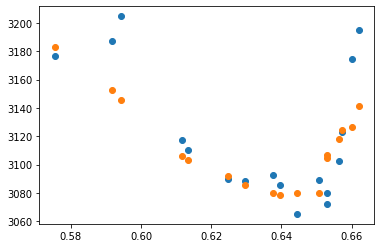

In [202]:
plt.scatter(df_features_test["Percentage Vaccinated"], df_target_test)
plt.scatter(df_features_test["Percentage Vaccinated"], pred)

### Adding air traffic as a variable (Date, Still Hospitalised, % Vaccinated, Passengers)

In [19]:
# Extract feature and target
df_feature, df_target = get_features_targets(df,["Date", "Still Hospitalised", "Percentage Vaccinated", "Passengers"],["STI Price"])

df_features = poly_features(df_feature, "Percentage Vaccinated", "Percentage Vaccinated", 2)

# normalize features
# df_features = normalize_z(df_features)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z) # concatenating for the y intercept
target = prepare_target(df_target_train)


iterations = 10000
alpha = 0.01
num_rows = X.shape[0] #Number of Rows
num_cols = X.shape[1] #Number of Columns 
beta = np.random.randn(num_cols,1) / np.sqrt(num_rows) #Weight Initialization

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print(beta)
pred = predict(df_features_test,beta)

evaluate_model(df_target_test, pred)

[[3112.31261905]
 [  99.29287322]
 [ -18.96824249]
 [-103.50011738]
 [  12.83351892]]
mse :                     0
STI Price  870.962402

r2 : STI Price    0.584748
dtype: float64
adjusted r2 : STI Price    0.557064
dtype: float64


/var/folders/p7/pbcvldqj5d9b2zjtyfr5m2mm0000gn/T/ipykernel_27273/96265623.py:68: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  mse = np.matmul(error.T,error)/n


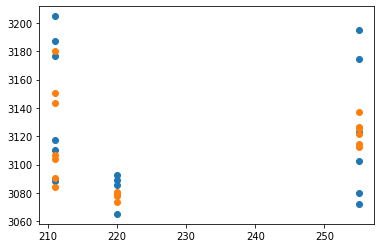

In [21]:
plt.scatter(df_features_test["Passengers"], df_target_test)
plt.scatter(df_features_test["Passengers"], pred)